# Predicting the Stock Market

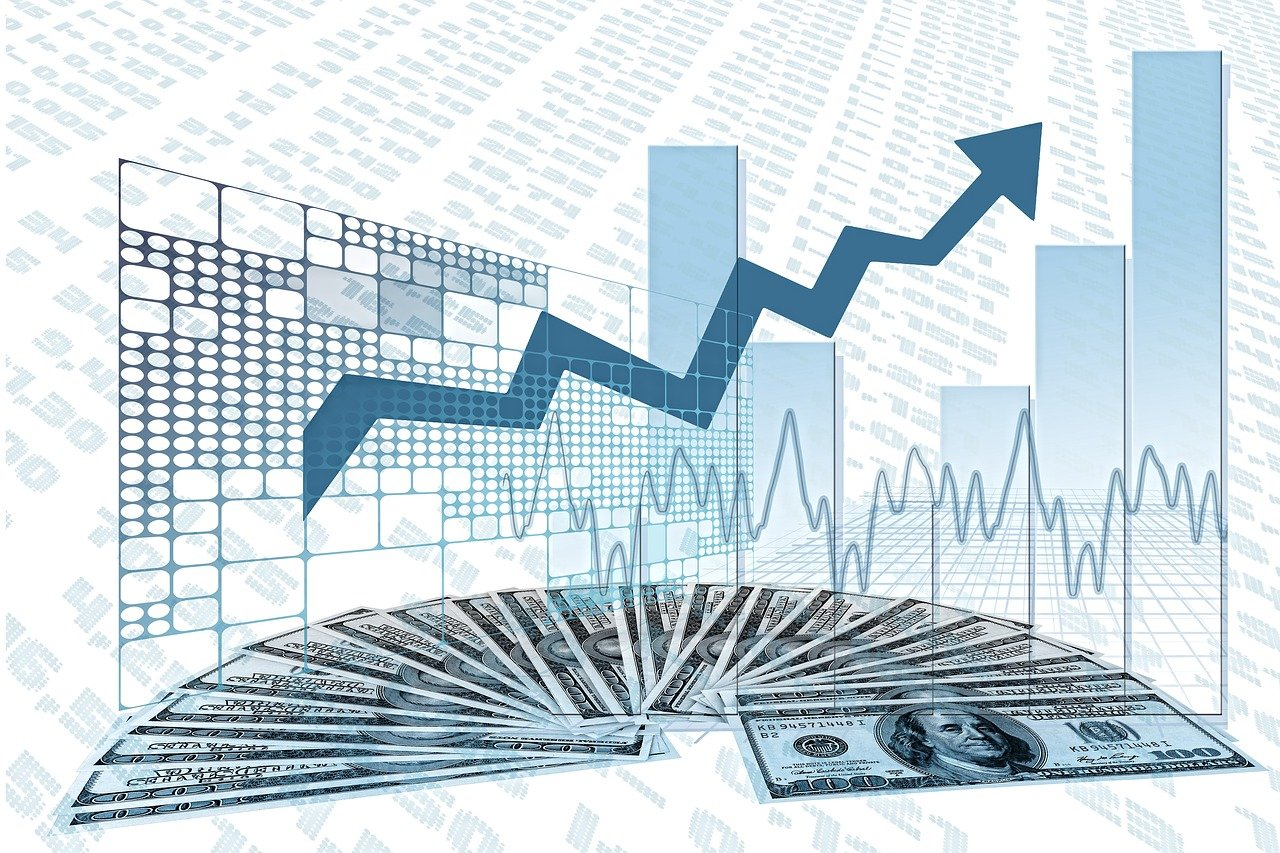

In this project, we'll work with the historical data on the prices of the S&P500 Index, which is a stock market index that aggregates the stock prices of 500 large companies, to make predictions about future prices. Predicting whether an index goes up or down helps forecast how the stock market and the economy as a whole performs. Also, it could allow traders of Exchange Traded Funds (ETF) to make money on the stock market.

The dataset contains the data from 1950 to 2015, each row represents a daily record of the price of the S&P500 Index. The columns of the dataset are:
- `Date` – the date of the record.
- `Open` – the opening price of the day (when trading starts).
- `High` – the highest trade price during the day.
- `Low` – the lowest trade price during the day.
- `Close` – the closing price for the day (when trading is finished).
- `Volume` – the number of shares traded.
- `Adj Close` – the daily closing price, adjusted retroactively to include any corporate actions (more information about it [here](https://www.investopedia.com/terms/a/adjusted_closing_price.asp)).

We'll be using this dataset to develop a predictive model training it with the data for 1950-2012 and trying to make predictions for 2013-2015.
### Summary of Results
We generated and experimented with a wide range of indicators aggregating information from the prior rows, and selected those ones that allow creating the most accurate linear regression model. The model performance was improved by a further transformation of the features and trying all their possible combinations. The lowest obtained MAE value with this approach is 15.813. Furthermore, we made price predictions one day ahead for any particular date using all the previous historical data and managed to decrease the error significantly (up to 1.56).
## Data Downloading and Cleaning

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from itertools import combinations

pd.options.display.float_format = '{:.2f}'.format

sp500 = pd.read_csv('sphist.csv')

print(f'{sp500.dtypes}\n\n'
      f'\033[1mNumber of missing values in the dataframe:\033[0m {sp500.isnull().sum().sum()}')
sp500.head()

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

Number of missing values in the dataframe: 0


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.42,2090.42,2066.78,2077.07,4043820000.00,2077.07
1,2015-12-04,2051.24,2093.84,2051.24,2091.69,4214910000.00,2091.69
2,2015-12-03,2080.71,2085.00,2042.35,2049.62,4306490000.00,2049.62
3,2015-12-02,2101.71,2104.27,2077.11,2079.51,3950640000.00,2079.51
4,2015-12-01,2082.93,2103.37,2082.93,2102.63,3712120000.00,2102.63


Let's convert the `Date` column to datetime to be able to do date comparisons and sort the dataframe on this column: 

In [2]:
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.sort_values('Date').reset_index(drop=True)

print(f"\033[1mInitial date:\033[0m {sp500['Date'].min().date()}\n"
      f"\033[1mFinal date:\033[0m   {sp500['Date'].max().date()}\n\n"
      f'{sp500.dtypes}')

sp500.head()

Initial date: 1950-01-03
Final date:   2015-12-07

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object


,Date,Open,High,Low,Close,Volume,Adj Close
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.00,16.66
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.00,16.85
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.00,16.93
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.00,16.98
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.00,17.08


Before proceeding, let's take a look at the overall evolution of the S&P500 Index from 1950 to 2015:

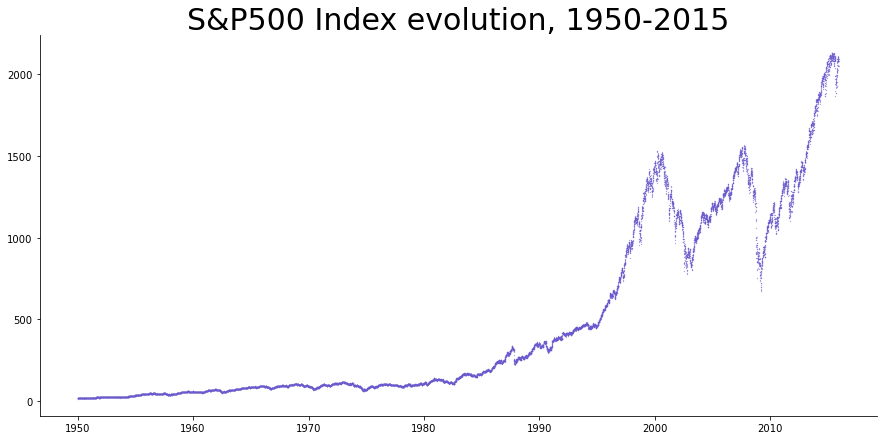

In [3]:
plt.figure(figsize=(15, 7))
plt.scatter(sp500['Date'], sp500['Close'], c='slateblue', s=0.05)
plt.title('S&P500 Index evolution, 1950-2015', fontsize=30)
sns.despine()
plt.show()

We can see that throughout the years, especially starting from the middle of the 1990s, the S&P500 Index curve was quite bumpy, going up and down, sometimes drastically, depending on the economical situation in the USA in each period of time. However, the overall trend is always growing.
## Generating Indicators
Datasets taken from the stock market represent sequential time series where each observation comes a day after the previous observation and depends on it. To account for this fact and make our model more accurate, we can generate indicators that aggregate information from multiple prior rows. Let's create the following indicators:

- the **average price** for the past 5 days / 30 days / 365 days,
- the **ratio** between the average price for the past 5 days and the average price for the past 365 days,
- the **standard deviation** of the price over the past 5 days / 30 days / 365 days,
- the **ratio** between the standard deviation for the past 5 days and the standard deviation for the past 365 days,
- the **average volume** over the past 5 days / 30 days / 365 days,
- the **ratio** between the average volume over the past 5 days and the average volume over the past 365 days,
- the **standard deviation** of the average volume over the past 5 days / 30 days / 365 days,
- the **ratio** between the standard deviation of the average volume over the past 5 days and the standard deviation of the average volume over the 365 days,
- the **year** component of the date,
- the **month** component of the date,
- the **day of week**,
- the **day** component of the date.

Here *days* mean *trading days* (without holidays or weekends) and *price* means the *closing price* for a trading day. When creating the indicators above, we should be careful to use only the previous data for each row and not include the current price in these calculations, since we want exactly to teach the model how to predict the current price from historical prices.

Let's create the indicators above:

In [4]:
def rolling_mean(feature, window):
    return sp500[feature].rolling(window, closed='left').mean()

def rolling_std(feature, window):
    return sp500[feature].rolling(window, closed='left').std()

avg_5 = rolling_mean('Close', 5)
avg_30 = rolling_mean('Close', 30)
avg_365 = rolling_mean('Close', 365)
ratio_avg_5_365 = avg_5 / avg_365
std_5 = rolling_std('Close', 5)
std_30 = rolling_std('Close', 30)
std_365 = rolling_std('Close', 365)
ratio_std_5_365 = std_5 / std_365
avg_vol_5 = rolling_mean('Volume', 5)
avg_vol_30 = rolling_mean('Volume', 30)
avg_vol_365 = rolling_mean('Volume', 365)
ratio_avg_vol_5_365 = avg_vol_5 / avg_vol_365
std_vol_5 = rolling_std('Volume', 5)
std_vol_30 = rolling_std('Volume', 30)
std_vol_365 = rolling_std('Volume', 365)
ratio_std_vol_5_365 = std_vol_5 / std_vol_365
year = sp500['Date'].dt.year
month = sp500['Date'].dt.month
day_of_week = sp500['Date'].dt.dayofweek
day = sp500['Date'].dt.day

sp500_updated = pd.concat([sp500, avg_5, avg_30, avg_365, ratio_avg_5_365, 
                           std_5, std_30, std_365, ratio_std_5_365, 
                           avg_vol_5, avg_vol_30, avg_vol_365, ratio_avg_vol_5_365,
                           std_vol_5, std_vol_30, std_vol_365, ratio_std_vol_5_365, 
                           year, month, day_of_week, day], axis=1)

sp500_updated.columns = list(sp500.columns) + ['avg_5', 'avg_30', 'avg_365', 'ratio_avg_5_365', 
                                               'std_5', 'std_30', 'std_365', 'ratio_std_5_365',
                                               'avg_vol_5', 'avg_vol_30', 'avg_vol_365', 'ratio_avg_vol_5_365',
                                               'std_vol_5', 'std_vol_30', 'std_vol_365', 'ratio_std_vol_5_365',
                                               'year', 'month', 'day_of_week', 'day']

pd.set_option('max_columns', sp500_updated.shape[1])
sp500_updated.head(7)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_5,avg_30,avg_365,ratio_avg_5_365,std_5,std_30,std_365,ratio_std_5_365,avg_vol_5,avg_vol_30,avg_vol_365,ratio_avg_vol_5_365,std_vol_5,std_vol_30,std_vol_365,ratio_std_vol_5_365,year,month,day_of_week,day
0,1950-01-03,16.66,16.66,16.66,16.66,1260000.00,16.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,1,3
1,1950-01-04,16.85,16.85,16.85,16.85,1890000.00,16.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,2,4
2,1950-01-05,16.93,16.93,16.93,16.93,2550000.00,16.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,3,5
3,1950-01-06,16.98,16.98,16.98,16.98,2010000.00,16.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,4,6
4,1950-01-09,17.08,17.08,17.08,17.08,2520000.00,17.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1,0,9
5,1950-01-10,17.03,17.03,17.03,17.03,2160000.00,17.03,16.90,NaN,NaN,NaN,0.16,NaN,NaN,NaN,2046000.00,NaN,NaN,NaN,529650.83,NaN,NaN,NaN,1950,1,1,10
6,1950-01-11,17.09,17.09,17.09,17.09,2630000.00,17.09,16.97,NaN,NaN,NaN,0.09,NaN,NaN,NaN,2226000.00,NaN,NaN,NaN,298043.62,NaN,NaN,NaN,1950,1,2,11


We created the indicators, but also we ended up with having missing values in our dataframe:

In [5]:
print(f'\033[1mMissing values by column, in %:\033[0m\n{sp500_updated.isnull().sum().mul(100).div(len(sp500_updated))}')

Missing values by column, in %:
Date                  0.00
Open                  0.00
High                  0.00
Low                   0.00
Close                 0.00
Volume                0.00
Adj Close             0.00
avg_5                 0.03
avg_30                0.18
avg_365               2.20
ratio_avg_5_365       2.20
std_5                 0.03
std_30                0.18
std_365               2.20
ratio_std_5_365       2.20
avg_vol_5             0.03
avg_vol_30            0.18
avg_vol_365           2.20
ratio_avg_vol_5_365   2.20
std_vol_5             0.03
std_vol_30            0.18
std_vol_365           2.20
ratio_std_vol_5_365   2.20
year                  0.00
month                 0.00
day_of_week           0.00
day                   0.00
dtype: float64


Let's remove the rows with missing values:

In [6]:
num_rows_before = sp500_updated.shape[0]
sp500_updated = sp500_updated.dropna().reset_index(drop=True)
num_rows_after = sp500_updated.shape[0]

print(f'\033[1mNumber of removed rows:\033[0m {num_rows_before - num_rows_after}')
sp500_updated.head(3)

Number of removed rows: 365


,Date,Open,High,Low,Close,Volume,Adj Close,avg_5,avg_30,avg_365,ratio_avg_5_365,std_5,std_30,std_365,ratio_std_5_365,avg_vol_5,avg_vol_30,avg_vol_365,ratio_avg_vol_5_365,std_vol_5,std_vol_30,std_vol_365,ratio_std_vol_5_365,year,month,day_of_week,day
0,1951-06-19,22.02,22.02,22.02,22.02,1100000.00,22.02,21.80,21.70,19.45,1.12,0.26,0.47,1.79,0.14,1196000.00,1707666.67,1989479.45,0.60,142232.20,1566790.45,772310.65,0.18,1951,6,1,19
1,1951-06-20,21.91,21.91,21.91,21.91,1120000.00,21.91,21.90,21.68,19.46,1.13,0.21,0.44,1.79,0.12,1176000.00,1691666.67,1989041.10,0.59,148425.07,1570585.40,772771.10,0.19,1951,6,2,20
2,1951-06-21,21.78,21.78,21.78,21.78,1100000.00,21.78,21.97,21.66,19.48,1.13,0.09,0.41,1.79,0.05,1188000.00,1675666.67,1986931.51,0.60,138816.43,1573992.69,774092.10,0.18,1951,6,3,21


Practically, we removed the first 365 rows representing the first trading "year", i.e., more than a calendar year, considering all the accumulated weekends, holidays, and any other non-trading days. This is because some of the indicators use 365 days of historical data and hence some rows don't have enough prior data to generate those indicators.

Now, we can remove also the columns `Open`, `High`, `Low`, `Volume`, and `Adj Close`:

In [7]:
sp500_updated = sp500_updated.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1)
sp500_updated.head(3)

,Date,Close,avg_5,avg_30,avg_365,ratio_avg_5_365,std_5,std_30,std_365,ratio_std_5_365,avg_vol_5,avg_vol_30,avg_vol_365,ratio_avg_vol_5_365,std_vol_5,std_vol_30,std_vol_365,ratio_std_vol_5_365,year,month,day_of_week,day
0,1951-06-19,22.02,21.80,21.70,19.45,1.12,0.26,0.47,1.79,0.14,1196000.00,1707666.67,1989479.45,0.60,142232.20,1566790.45,772310.65,0.18,1951,6,1,19
1,1951-06-20,21.91,21.90,21.68,19.46,1.13,0.21,0.44,1.79,0.12,1176000.00,1691666.67,1989041.10,0.59,148425.07,1570585.40,772771.10,0.19,1951,6,2,20
2,1951-06-21,21.78,21.97,21.66,19.48,1.13,0.09,0.41,1.79,0.05,1188000.00,1675666.67,1986931.51,0.60,138816.43,1573992.69,774092.10,0.18,1951,6,3,21


## Making Predictions
Now, we're ready to create the first version of a predictive model. We'll split the dataframe into `train` (any record earlier than 2013) and `test` (all the other records), apply a linear regression algorithm and use the mean absolute error (MAE) as an error metric. Since we're going to tune our model later, let's gather all the steps in a function:

In [8]:
def train_and_test(features=False):
    train = sp500_updated[sp500_updated['Date'] < datetime(year=2013, month=1, day=1)]
    test = sp500_updated[sp500_updated['Date'] >= datetime(year=2013, month=1, day=1)]
    
    # Creating a list of features if it isn't provided
    if not features:
        features = train.columns.drop(['Date', 'Close']).tolist()
        
    X_train = train[features]
    X_test = test[features]
    y_train = train['Close']
    y_test = test['Close']

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae

mae = train_and_test()
print(f'\033[1mMAE\033[0m: {mae:.2f}')

MAE: 16.18


## Improving Error
Let's see what can be done to decrease the error of the price prediction.

First, we can check how the numeric variables used in model building correlate with the target variable `Close`:

In [9]:
pd.options.display.float_format = '{:.4f}'.format

corr_price = sp500_updated.corr()['Close'].abs().sort_values(ascending=False).drop('Close')
corr_price

avg_5                 0.9998
avg_30                0.9992
avg_365               0.9889
year                  0.8721
std_365               0.8161
avg_vol_30            0.7869
avg_vol_365           0.7849
avg_vol_5             0.7809
std_30                0.7786
std_5                 0.7224
std_vol_30            0.6843
std_vol_365           0.6841
std_vol_5             0.6172
ratio_std_5_365       0.0870
ratio_std_vol_5_365   0.0703
ratio_avg_5_365       0.0478
ratio_avg_vol_5_365   0.0123
month                 0.0057
day_of_week           0.0033
day                   0.0015
Name: Close, dtype: float64

The features `ratio_std_5_365`, `ratio_std_vol_5_365`, `ratio_avg_5_365`, `ratio_avg_vol_5_365`, `month`, `day_of_week`, and `day` demonstrated almost no correlation with the closing price, so we'll remove them from the dataset:

In [10]:
sp500_updated = sp500_updated.drop(corr_price[corr_price < 0.6].index, axis=1)
sp500_updated.corr()['Close'].abs().sort_values(ascending=False).drop('Close')

avg_5         0.9998
avg_30        0.9992
avg_365       0.9889
year          0.8721
std_365       0.8161
avg_vol_30    0.7869
avg_vol_365   0.7849
avg_vol_5     0.7809
std_30        0.7786
std_5         0.7224
std_vol_30    0.6843
std_vol_365   0.6841
std_vol_5     0.6172
Name: Close, dtype: float64

Let's check the model performance now:

In [11]:
mae = train_and_test()
print(f'\033[1mMAE\033[0m: {mae:.2f}')

MAE: 16.17


The error decreased rather insignificantly. 

Let's try another approach: find all the possible combinations of all the numerical features in the dataframe, build a model for each, estimate the error, and detect the combination of features with the lowest error. We'll exclude from consideration the univariate models (based on only 1 feature) and also the model that uses all the numerical features (we've just seen that in the latter case, the error didn't improve much).

In [12]:
all_features = sp500_updated.drop(['Date', 'Close'], axis=1).columns.tolist()
all_combinations = []

for i in range(2, len(all_features)):
    all_combinations += combinations(all_features, i)
print(f'\033[1mNumber of all combinations of the features:\033[0m {len(all_combinations):,}\n\n')

minimum = 16
for feature_set in all_combinations:
    mae = train_and_test(list(feature_set))
    if mae < minimum:
        print(f'\033[1mFeatures:\033[0m {list(feature_set)}\n\033[1mMAE:\033[0m {mae:.3f}\n')
        minimum = mae
round(minimum, 3)

Number of all combinations of the features: 8,177


Features: ['avg_5', 'avg_vol_365', 'std_vol_365']
MAE: 15.901

Features: ['avg_5', 'std_30', 'avg_vol_365', 'std_vol_365']
MAE: 15.877

Features: ['avg_5', 'std_365', 'avg_vol_365', 'std_vol_365']
MAE: 15.854

Features: ['avg_5', 'std_30', 'std_365', 'avg_vol_365', 'std_vol_365']
MAE: 15.846

Features: ['avg_5', 'std_30', 'avg_vol_365', 'std_vol_5', 'std_vol_365']
MAE: 15.835

Features: ['avg_5', 'std_365', 'avg_vol_365', 'std_vol_5', 'std_vol_365']
MAE: 15.828

Features: ['avg_5', 'std_30', 'std_365', 'avg_vol_365', 'std_vol_5', 'std_vol_365']
MAE: 15.813



15.813

Hence the lowest error that we can obtain is 15.813, when using the features `avg_5`, `std_30`, `std_365`, `avg_vol_365`, `std_vol_5`, and `std_vol_365`:

In [13]:
mae = train_and_test(features=['avg_5', 'std_30', 'std_365', 'avg_vol_365', 'std_vol_5', 'std_vol_365'])
print(f'\033[1mMAE\033[0m: {mae:.3f}')

MAE: 15.813


## Making Predictions Only One Day Ahead
To further improve the model accuracy and simulate more closely what the traders do, let's try making predictions only one day ahead, i.e., predicting the price for a particular date using all the previous historical data. To do so, we'll update our function to take into account also such cases:

In [14]:
# Updating the function
def train_and_test(features=False, year=False, month=False, day=False):
    train = sp500_updated[sp500_updated['Date'] < datetime(year=2013, month=1, day=1)]
    test = sp500_updated[sp500_updated['Date'] >= datetime(year=2013, month=1, day=1)]

    # Creating train and test sets in the case when the exact data is provided
    if year:
        train = sp500_updated[sp500_updated['Date'] <= datetime(year=year, month=month, day=day)]
        test = train.iloc[-1].to_frame().T
        train = train[:-1]

    # Creating a list of features if it isn't provided
    if not features:
        features = train.columns.drop(['Date', 'Close']).tolist()

    X_train = train[features]
    X_test = test[features]
    y_train = train['Close']
    y_test = test['Close']

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    if year:
        return print(f'{day}/{month}/{year}\n\033[1mPrice:\033[0m {predictions[0]:,.0f}\n\033[1mMAE:\033[0m {mae:.2f}\n')
    return print(f'\033[1mMAE\033[0m: {mae:.2f}\n')

# Checking the dates 5/5/2014, 17/6/2015, and 25/11/2013
train_and_test(year=2014, month=5, day=5)
train_and_test(features=['avg_5', 'std_30', 'std_365', 'avg_vol_365', 'std_vol_5', 'std_vol_365'],
               year=2015, month=6, day=17)
train_and_test(features=['avg_5', 'std_30', 'std_365', 'avg_vol_365', 'std_vol_5', 'std_vol_365'],
               year=2013, month=11, day=25)

5/5/2014
Price: 1,882
MAE: 2.43

17/6/2015
Price: 2,099
MAE: 1.56

25/11/2013
Price: 1,797
MAE: 4.99



We see that in such cases, we can decrease the error considerably, even though the outcome depends on the exact date we want to check, and also, it still depends on the selected set of features. The `test` set here consists virtually of one day: the one we're checking.
## Conclusion
In this project, we worked with the historical data on the S&P500 Index (1950-2015) and developed a model for predicting future prices. Below are the main results:
- A wide range of indicators were generated aggregating information from multiple prior rows and better representing each entry numerically.


- A predictive linear regression model was built. The model was trained on all the records earlier than 2013 and tested on more recent records. The starting value of the MAE error, after proper data cleaning and initial transforming, was 16.18.


- To improve the accuracy of the model, the features were further transformed, then all their possible combinations were run. The lowest obtained MAE value is 15.813, for a model based on the following features:
  - the average price for the past 5 days,
  - the standard deviation of the price over the past 30 days and 365 days,
  - the average volume over the past 365 days,
  - the standard deviation of the average volume over the past 5 days and 365 days,
  

- To further improve the model performance and simulate the real-world activity of traders more closely, another approach was tried: predicting the price only one day ahead for a particular date using all the previous historical data. The error decreased significantly (up to 1.56), even though the outcome depends on the exact date to be checked, and also, it still depends on the selected set of features.


- **Potential ways forward**: trying other ML algorithms rather than the linear regression model, incorporating outside data (weather conditions the day before, the amount of Twitter activity around certain stocks, etc.), including more recent data, making a high-resolution model (not days but hours / minutes / seconds), making predictions for individual stocks instead of the S&P500 Index.